# Primary research question

# Task Overview: 
## fMRI task: 
Each participant went through four runs, 2 runs for each context (hanging out with friends or or studying at school). Within each run, we asked participants to what extent each trait describe them either in the present context. Each run contains 77 trials, with 64 positive traits presented with a random order and 13 catch trials where we asked the participants to press a specific number. Participants didn't need to make any response for the trait trials. The order of the context were counterbalanced
## post fMRI task: 
Participants rated each trait for both contexts on a 7-point Likert scale. The order of the traits were randomized and the order of the contexts were counterbalanced

# Dataset Overview: 
The present dataset contains 41 participants

# Data Processing: 
## 1. fMRI Prep: 
* registration looks normal
* we have some participants with extended movement. See thresholdTestOutput.csv for the mean & max of frame displacement for each run. It also contains the number of volumns above different levels of FD thresholds. 
## 2. FEAT level 1: 
* EV file: 3 parameters: trait onset, duration (3), weight (1)
* confounds: 
    * motion parameters: 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z','rot_z_derivative1'
    * Framewise displacement: marked 1 if the FD > 0.5
* fsl parameters: 
    * no slice timing correction 
    * spatial smoothing: 4.0mm
    * Highpass temporal filtering  
## 3. Beta extraction
* Used the extraction script provided by Talor (method: LSA).  
## 4. Rating RDMs: 
* re-order the post-fMRI trait ratings for each context based on the order of the traitList.csv to keep it consistent with neural RDMs. 
* pair-wise differences in ratings were calculated by the first trait rating - second trait rating 



# Research Questions and Analysis Plans: 
## Q1: Where do the neural representations of self-related traits fluctuate across contexts?
* Within which ROIs does same context correlations between neural RDMs > cross context correlations between neural RDMs
## Q1.5: Within those ROIs where the neural representations of self-related traits fluctuate, does the degree of the flectuation tracks the degree of the differences in trait ratings across context? 
* Within previously identified ROIs does the correlation between the neural RDMs from each context correlate with the average of absolute changes across all traits? 
## Q2: Where do the neural representations of self-related traits reflect context specific self-evaluation (working self concepts)?
* Within which ROIs does the correlation between neural RDMs and rating RDMs in the friend context > those of the school context and vise versa

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import argparse
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, two_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn import plotting, image
from bids import BIDSLayout, BIDSValidator

/Users/BerniceCheung/Documents/ResearchProject/DEV/DEV_RS/dev_rs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# load outputs from individual RSA analysis (index are subject IDs)
root_dir = "/Users/BerniceCheung/Documents/ResearchProject/socialContext"

# correlations of neuralRDMs between the two runs of a given context
sameCorr_friend =  pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_sameCorr_ROI_friend.csv'), index_col=0)
sameCorr_school =  pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_sameCorr_ROI_school.csv'), index_col=0)

# correlations of neuralRDMs between runs of each context
diffCorr_F1S2 = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_diffCorr_ROI_F1S2.csv'), index_col=0)
diffCorr_F2S1 = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_diffCorr_ROI_F2S1.csv'), index_col=0)

# RSA between the neuralRDMs and ratingRDMs of a given context
friend_RSA = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'contextRSA_friend.csv'), index_col=0)
school_RSA = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'contextRSA_school.csv'), index_col=0)

In [3]:
# load the whole brain parcellation mask
mask = Brain_Data(os.path.join(root_dir, 'brainMask', 'Neurosynth Parcellation', 'Neurosynth Parcellation_2.nii.gz'))

# get a list of ROIs
mask_x = expand_mask(mask)

# Same context Neural RDM correlation

Procedures for calculating same context Neural RDM correlation:  
1. Extracted beta from the first level GLM in which we regressed neural activity onto the onset of traits within each run  
2. For each run within each subject, rearrange the order of the betas to match with the order of reference trait list
3. a neural RDM for each run was generated by 1 - pair-wise correlation distance of beta. (this similarity index ranges from -1 to 1, higher means more similar)  
4. Same context correlation was generated for each context (friend run 1 was correlated with friend run 2; school run 1 was correlated with school run 1)  
5. Different context correlatoin was generated by correlating friend run 1 with school run 2 (F1S2) and friend run2 with school run 1 (F2S1)  
6. By contrasting same context correlation with different contract correalation, we can verify if and where do self-evaluation vary across context

## Friend context

In [4]:
friendCorr_1sample = []

for i in sameCorr_friend:
    friendCorr_1sample.append(one_sample_permutation(fisher_r_to_z(sameCorr_friend[i])))

In [5]:
friendCorr_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, friendCorr_1sample)]).sum()
friendCorr_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, friendCorr_1sample)]).sum()

In [6]:
friendCorr_thresholded = threshold(friendCorr_1sample_r, friendCorr_1sample_p, thr=0.005)

In [7]:
friendCorr_thresholded_nifti = friendCorr_thresholded.to_nifti()

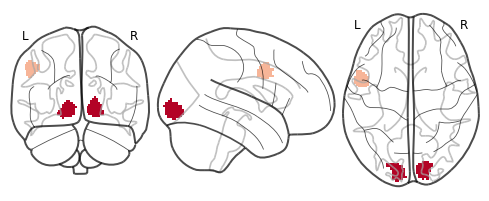

In [8]:
plotting.plot_glass_brain(friendCorr_thresholded_nifti, cmap='coolwarm')

The figure above shows the ROIs in which the permulated one-sample t-test of the friend context correlation pass the threshold at 0.005. 

## School context

In [99]:
schoolCorr_1sample = []

for i in sameCorr_school:
    schoolCorr_1sample.append(one_sample_permutation(fisher_r_to_z(sameCorr_school[i])))

In [100]:
schoolCorr_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, schoolCorr_1sample)]).sum()
schoolCorr_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, schoolCorr_1sample)]).sum()

In [105]:
schoolCorr_thresholded = threshold(schoolCorr_1sample_r, schoolCorr_1sample_p, thr=0.005)

In [106]:
schoolCorr_thresholded_nifti = schoolCorr_thresholded.to_nifti()

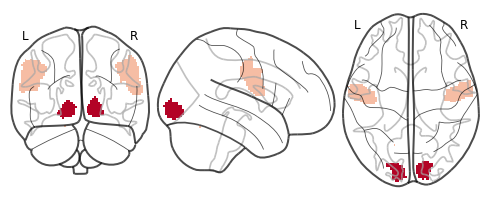

In [107]:
plot_glass_brain(schoolCorr_thresholded_nifti, cmap='coolwarm')

These are the same regions as friend context. However, these are not the regions for self-perception

# Different context neural RDM correlation

## Correlation between friend run 1 and school run 2 (F1S2)

In [137]:
F1S2_1sample = []

for i in diffCorr_F1S2:
    F1S2_1sample.append(one_sample_permutation(fisher_r_to_z(diffCorr_F1S2[i])))

In [138]:
F1S2_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, F1S2_1sample)]).sum()
F1S2_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, F1S2_1sample)]).sum()

In [139]:
F1S2_thresholded = threshold(F1S2_1sample_r, F1S2_1sample_p, thr=0.005)

In [140]:
F1S2_thresholded_nifti = F1S2_thresholded.to_nifti()

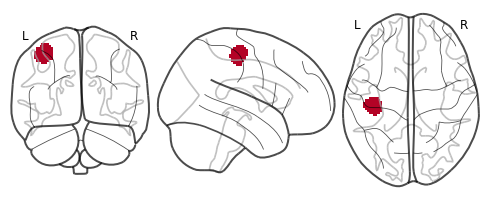

In [141]:
plot_glass_brain(F1S2_thresholded_nifti, cmap='coolwarm')

## Correlation between friend run 2 and school run 1 (F2S1)

In [142]:
F2S1_1sample = []

for i in diffCorr_F2S1:
    F2S1_1sample.append(one_sample_permutation(fisher_r_to_z(diffCorr_F2S1[i])))

In [143]:
F2S1_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, F2S1_1sample)]).sum()
F2S1_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, F2S1_1sample)]).sum()

In [151]:
F2S1_thresholded = threshold(F2S1_1sample_r, F2S1_1sample_p, thr=0.01)
F2S1_thresholded_nifti = F2S1_thresholded.to_nifti()

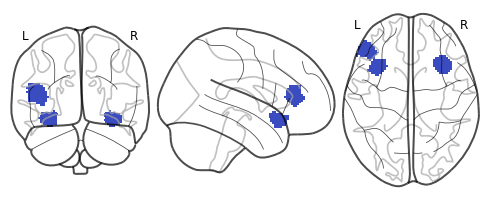

In [152]:
plot_glass_brain(F2S1_thresholded_nifti, cmap='coolwarm')

No ROI passed the threshold at 0.005, and the image above is threshold at 0.01 

# Comparisons between same context correlations and different context correlation

For each ROI, I substract the correlation coefficient of different context (F1S2 or F2S1) from the coefficient of same context. Then I transfer the difference in coefficient to a fisher z score, and ran a permulated (5000 times) one-sample t-test on the z score. I set the threshold at 0.005 for now just to look at the data.

## Contrast between friend same correlation and F1S2

In [112]:
friend_F1S2 = []

for i, j in zip(sameCorr_friend, diffCorr_F1S2):
    friend_F1S2.append(one_sample_permutation(fisher_r_to_z(sameCorr_friend[i]-diffCorr_F1S2[j])))

In [113]:
friend_F1S2_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, friend_F1S2)]).sum()
friend_F1S2_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, friend_F1S2)]).sum()


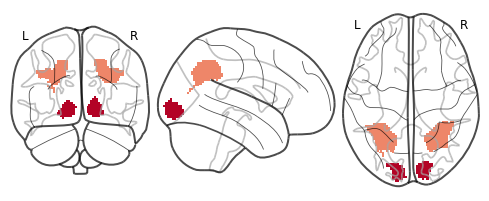

In [114]:
friend_F1S2_thresholded = threshold(friend_F1S2_r, friend_F1S2_p, thr=0.005).to_nifti()

plot_glass_brain(friend_F1S2_thresholded, cmap='coolwarm')

These are the ROIs where the correlation between 2 friend runs > the correlations between friend run 1 and school run 2

## Contrast between friend and F2S1

In [17]:
friend_F2S1 = []

for i, j in zip(sameCorr_friend, diffCorr_F2S1):
    friend_F2S1.append(one_sample_permutation(fisher_r_to_z(sameCorr_friend[i]-diffCorr_F2S1[j])))

In [115]:
friend_F2S1_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, friend_F2S1)]).sum()
friend_F2S1_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, friend_F2S1)]).sum()

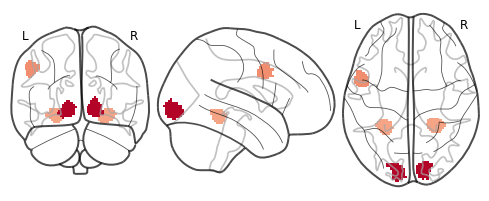

In [116]:
friend_F2S1_thresholded = threshold(friend_F2S1_r, friend_F2S1_p, thr=0.005).to_nifti()

plot_glass_brain(friend_F2S1_thresholded, cmap='coolwarm')

These are the ROIs where the correlation between 2 friend runs > the correlations between friend run 2 and school run 1

## The ROIs that pass the threshold for both friend - F1S2 and friend - F2S1

In [119]:
# convert the p value to a vector
friend_F1S2_pvalue = pd.DataFrame(friend_F1S2)['p'].values
friend_F2S1_pvalue = pd.DataFrame(friend_F2S1)['p'].values

# convert the p value to a binary value based on whether a p value of a ROI pass the threshold
friend_F1S2_b = (friend_F1S2_pvalue < 0.005).astype(int)
friend_F2S1_b = (friend_F2S1_pvalue < 0.005).astype(int)

In [120]:
# the ROI that pass the thrshold across both contracts
overlap = (friend_F1S2_b * friend_F2S1_b).tolist()

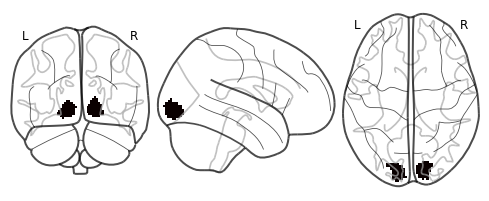

In [123]:
overlap_img = Brain_Data([x*y for x,y in zip(mask_x, overlap)]).sum()
plot_glass_brain(overlap_img.to_nifti())

The only overlap ROI of the 2 sets of contrast is the visual, which doesn't make sense to me, unless the correlations are too weak before we do the contrast

## Contrast between school and F1S2

In [20]:
school_F1S2 = []

for i, j in zip(sameCorr_school, diffCorr_F1S2):
    school_F1S2.append(one_sample_permutation(fisher_r_to_z(sameCorr_school[i]-diffCorr_F1S2[j])))

In [124]:
school_F1S2_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, school_F1S2)]).sum()
school_F1S2_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, school_F1S2)]).sum()


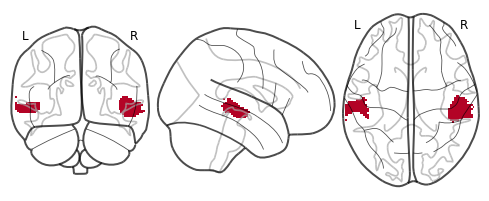

In [125]:
school_F1S2_thresholded = threshold(school_F1S2_r, school_F1S2_p, thr=0.005)

plot_glass_brain(school_F1S2_thresholded.to_nifti(), cmap='coolwarm')

## Contrast between school and F2S1

In [23]:
school_F2S1 = []

for i, j in zip(sameCorr_school, diffCorr_F2S1):
    school_F2S1.append(one_sample_permutation(fisher_r_to_z(sameCorr_school[i]-diffCorr_F2S1[j])))

In [126]:
school_F2S1_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, school_F2S1)]).sum()
school_F2S1_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, school_F2S1)]).sum()


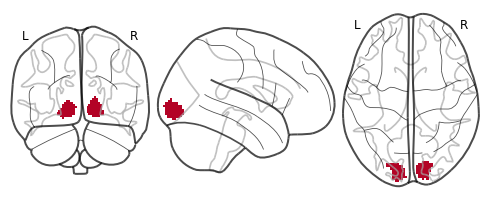

In [127]:
school_F2S1_thresholded = threshold(school_F2S1_r, school_F2S1_p, thr=0.005)

plot_glass_brain(school_F2S1_thresholded.to_nifti(), cmap='coolwarm')

There's no overlap ROI

# Group Level Context RSA

1. For each context within each subject, the trait ratings were re-ordered based on the reference trait list(same as the order of the beta)  
2. Rating RDM for each context was generated by pair-wise substraction (trait raitng 1 - trait rating 2 )  
3. context RSA was generated by calculating the spearman rank correlation between the neural RDM from the first run of each context with the corresponding rating RDM

## Friend context RSA

In [14]:
# one sample permutation for friend context RSA
friend_RSA_1sample = []

for i in friend_RSA:
    friend_RSA_1sample.append(one_sample_permutation(fisher_r_to_z(friend_RSA[i])))

In [16]:
# transform the permutated stats into an brain_data object
friend_RSA_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, friend_RSA_1sample)]).sum()
friend_RSA_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, friend_RSA_1sample)]).sum()

In [ ]:

#fdr_p = fdr(np.array([x['p'] for x in friend_RSA_1sample]), q=0.05)

#thresholded = threshold(friend_RSA_1sample_r, friend_RSA_1sample_p, thr=fdr_p)

#plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm')

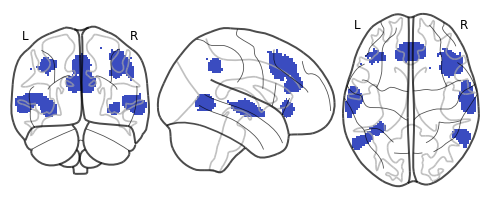

In [146]:
friend_RSA_thresholded = threshold(friend_RSA_1sample_r, friend_RSA_1sample_p, thr=0.005)

plot_glass_brain(friend_RSA_thresholded.to_nifti(), cmap='coolwarm')


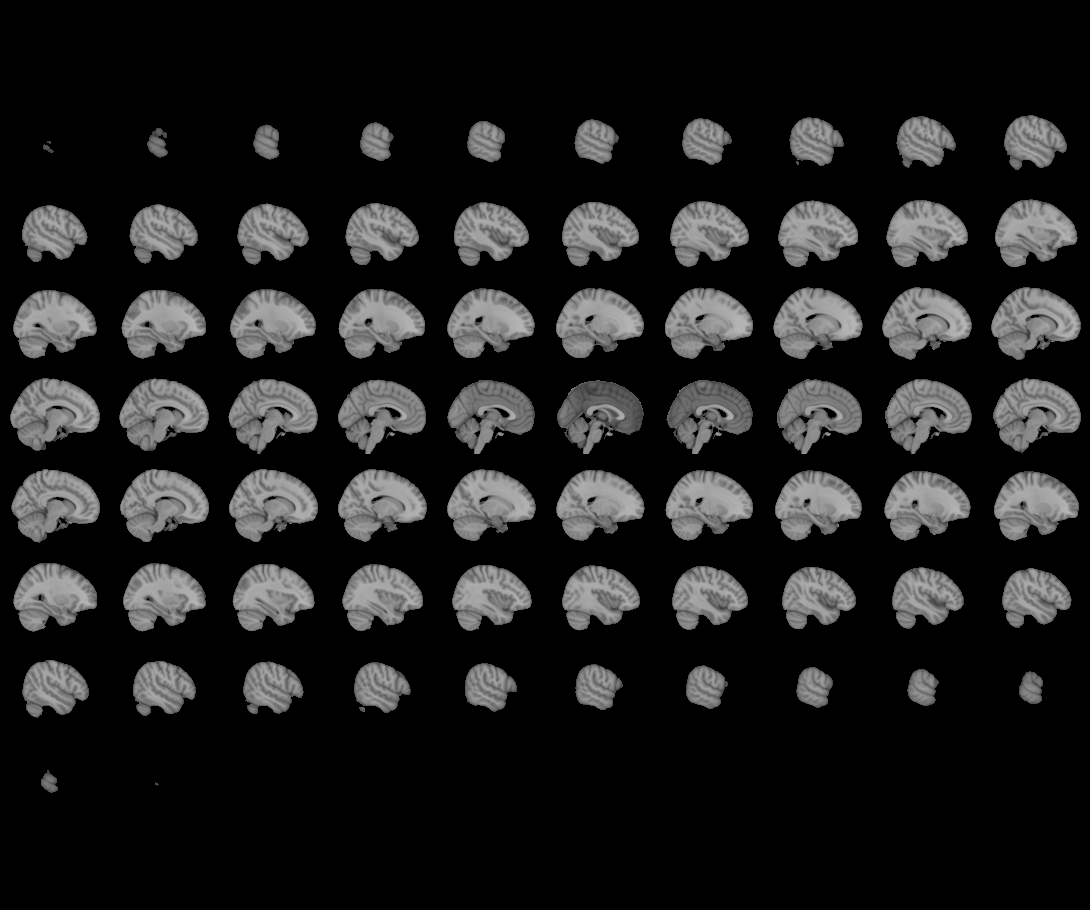
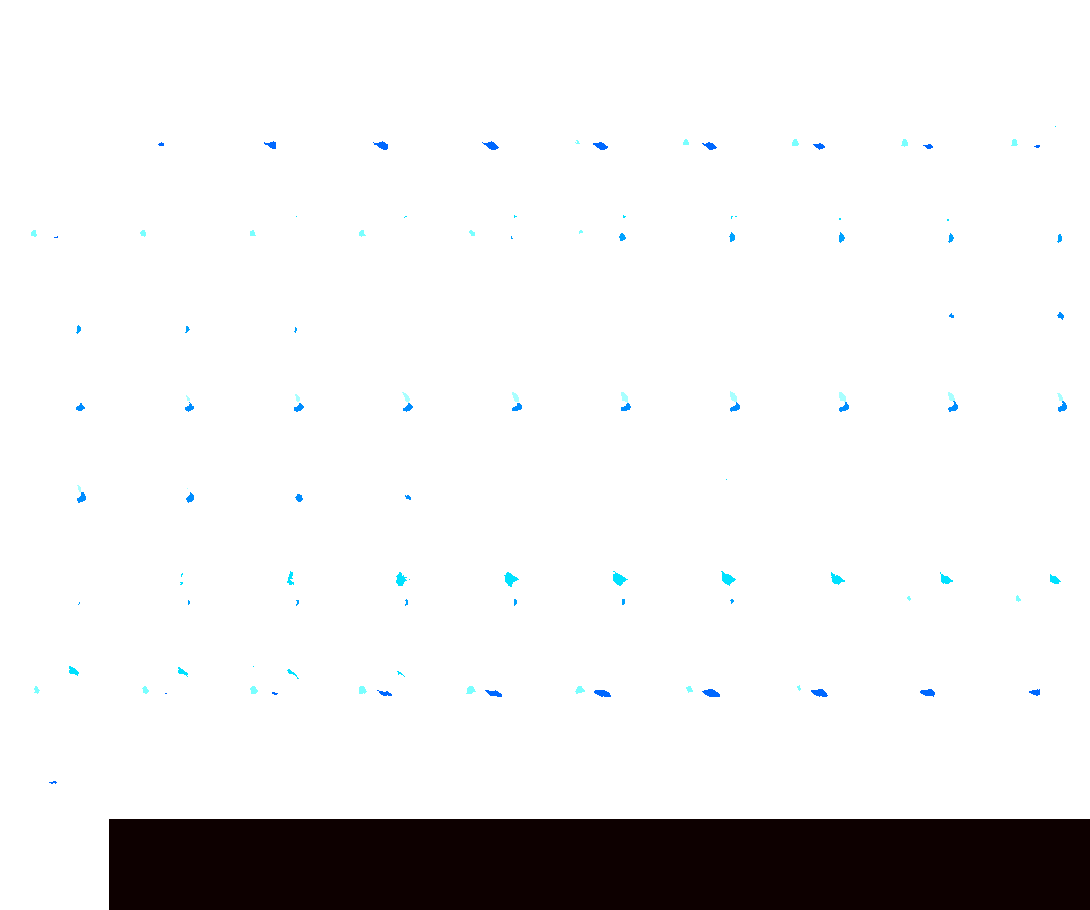

In [147]:
view_img(friend_RSA_thresholded.to_nifti())

The figure about should be interactive and you can move around to see the regions. It seems like DMPFC pass the 0.005 threshold? 

## School context RSA

In [132]:
# one sample permutation for school context RSA
school_RSA_1sample = []

for i in school_RSA:
    school_RSA_1sample.append(one_sample_permutation(fisher_r_to_z(school_RSA[i])))

In [133]:
# transform the permutated stats into an brain_data object
school_RSA_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, school_RSA_1sample)]).sum()
school_RSA_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, school_RSA_1sample)]).sum()

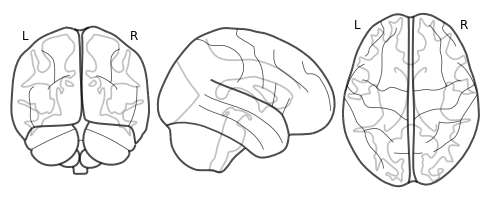

In [148]:
school_RSA_thresholded = threshold(school_RSA_1sample_r, school_RSA_1sample_p, thr=0.01)

plot_glass_brain(school_RSA_thresholded.to_nifti(), cmap='coolwarm')

No ROIs pass the threshold even when I adjusted it to 0.01